### Generate the Wadden Sea forcing data file

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

C:\Users\shami\Miniconda3\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


#### Read a World Ocean Database (WOD) nc file (rectangle near to the eastern part of the Wadden Sea) which is produced by Ocean Data Viewer (ODV) and smooth through years for depths less then 11 m, var1 is depth

In [2]:
ds = xr.open_dataset('wadden_sea.nc')
df = ds.to_dataframe()
df = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.var1 < 11)]
df = df[['longitude', 'latitude', 'date_time'
        ,'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'
        ,'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14']]
df.columns = ['longitude', 'latitude', 'date_time'
             ,'Depth', 'Temperature', 'Salinity', 'Oxygen', 'Phosphate', 'Silicate', 'Nitrate'
             ,'Nitrite', 'pH', 'Chlorophyll a', 'Plankton biomass', 'Alkalinity', 'NO2+NO3', 'pCO2']
df['Oxygen'] = df['Oxygen']*44.661 # 1 ml/l = 10^3/22.391 = 44.661 μmol/l
df['Day of year'] = df.date_time.dt.dayofyear.values

#### Make a mean year from a range of 11 years

In [3]:
dfyear = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.date_time < '2011-01-01 00:00:00.0')]
dfyear = dfyear.groupby(['Day of year']).mean()
dfyear = dfyear.reindex(index=range(1,366))

In [4]:
dfyear = dfyear.interpolate(method='linear',limit_direction='forward')
dfyear.loc[0:16,:] = dfyear[-1:].values
dfyear.loc[0:16,'Chlorophyll a'] = 0
dfyear = dfyear.interpolate(method='linear',limit_direction='both')
dfyear = dfyear.rolling(window=16).mean()
dfyear = dfyear.interpolate(method='linear',limit_direction='both')

#### Make three successive years from one and plot. Other parameters also will be produced for 3 succesive similar years to construct a nc file with input data for a fortran model which resolves water and sediments domains

In [5]:
df3years = dfyear.append([dfyear, dfyear])
df3years.index = range(1, len(df3years)+1)
df3years.index.name = "day"

Text(0, 0.5, 'Chlorophyll a')

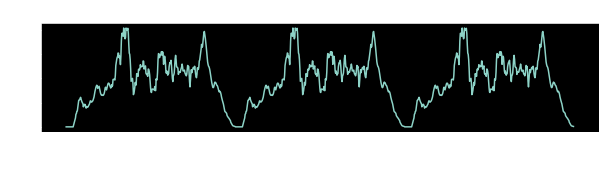

In [6]:
name = 'Chlorophyll a'
plt.plot(df3years.index, df3years[name]); plt.gcf().set_size_inches(10,2)
plt.title(name); plt.xlabel('Day'); plt.ylabel(name)

#### Plot dfyear, just visualization

Text(0, 0.5, 'Chlorophyll a')

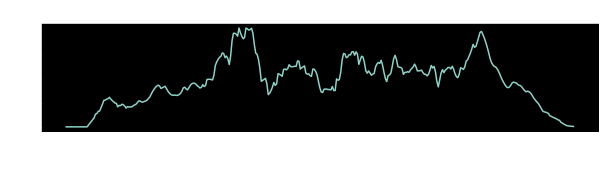

In [7]:
name = 'Chlorophyll a'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2)
plt.title(name); plt.xlabel('Day'); plt.ylabel(name)

Text(0, 0.5, 'Oxygen')

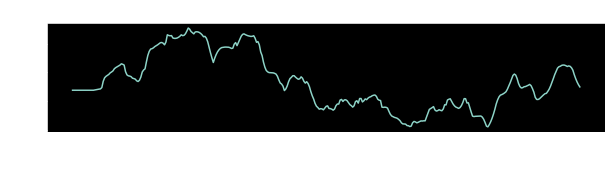

In [8]:
name = 'Oxygen'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2)
plt.title(name); plt.xlabel('Day'); plt.ylabel(name)

#### Read and process a text file downloaded from http://tsdata.hzg.de/ (Pile Hoernum1 station) with photosynthetically active radiation (PAR) data

In [9]:
dfpar = pd.read_csv('Pile_Hoernum1_PAR_20080101_20180608.dat', header=None, delim_whitespace=True
                   , skiprows=22)
dfpar[0] = dfpar[0] + ' ' + dfpar[1]
dfpar = dfpar.drop(1, axis=1)
dfpar[0] =  pd.to_datetime(dfpar[0])
dfpar = dfpar.rename(columns={0: 'date_time', 2: 'par', 3: 'flag'})
dfpar = dfpar[(dfpar['flag'] < 3) & (dfpar['par'] > 0)]
dfpar = dfpar.drop('flag', axis=1)
dfpar['Day of year'] = dfpar.date_time.dt.dayofyear.values
dfparmean = dfpar.groupby(['Day of year']).mean()
dfparmean = dfparmean.reindex(index=range(1,366))

In [10]:
dfparmean = dfparmean.interpolate(method='linear',limit_direction='both')
dfparmean = dfparmean.rolling(window=16).mean()
dfparmean = dfparmean.interpolate(method='linear',limit_direction='both')

In [11]:
# use a function described in utilities.py to generate a theoretical PAR
import utilities as ut
par_generated = np.zeros(365)
par_generated[:] = [ut.surface_radiation(x, 54) for x in range(365)]

In [12]:
par3years_generated = np.concatenate((par_generated, par_generated, par_generated), axis=None)

Text(0, 0.5, '$\\mu M\\,s^{-1}\\,m^{-2}$')

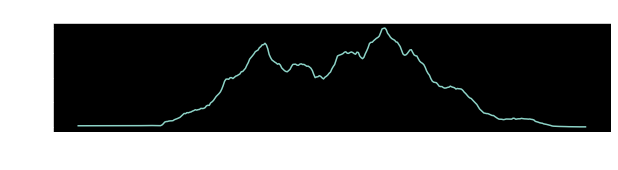

In [13]:
# visualize measured PAR
name = 'par'; plt.plot(dfparmean.index, dfparmean[name])
plt.gcf().set_size_inches(10,2); plt.title(name)
plt.xlabel('Day'); plt.ylabel('$\mu M\,s^{-1}\,m^{-2}$')

Text(0, 0.5, '$\\mu M\\,s^{-1}\\,m^{-2}$')

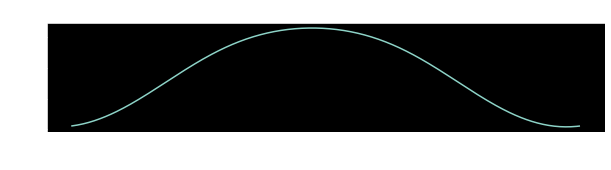

In [14]:
# visualize calculated PAR
name = 'par'; plt.plot(dfparmean.index, par_generated)
plt.gcf().set_size_inches(10,2); plt.title(name)
plt.xlabel('Day'); plt.ylabel('$\mu M\,s^{-1}\,m^{-2}$')

#### Generate yearly organic matter (OM) and gross primary production (gpp) according to Beusekom (1999)

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [16]:
ds = xr.open_dataset('data/test_flux/water.nc')
phy_df = ds['B_BIO_Phy'].to_dataframe()
phy_surface_ws = phy_df.groupby('z').get_group(0.625)

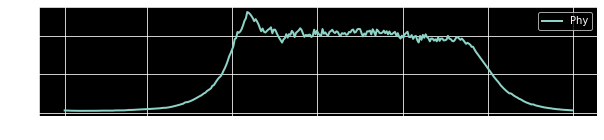

In [17]:
phy_surface_ws_year = phy_surface_ws.loc['2011-01-01':'2011-12-31']
phy_surface_ws_year = phy_surface_ws_year.reset_index()
fig = plt.figure(figsize=(10, 2)); ax = fig.add_subplot(1, 1, 1)
ax.plot(phy_surface_ws_year['time'], phy_surface_ws_year['B_BIO_Phy'], linewidth=2, label=r'Phy')
ax.legend(loc='best'); ax.grid(True)

In [39]:
from scipy import integrate

The original flux of OM is 110 $gC\,m^{-2} y^{-1}$ for the total water column, the Wadden sea has an average depth 2.5 meters, so concentration is 110/2.5 for $m^2$.

In [40]:
annual_flux_om = 110/2.5 * 1000# mg C m-2 y-1
#annual_flux_don = ((110/2.5)/12.011) * 1000 * (16/106)# mM N m-3 d-1

In [41]:
om_input = np.zeros(365)
day_flux = annual_flux_om/250
om_input[0:70] = day_flux
om_input[70:130] = 3*day_flux

In [42]:
om_input.sum()

44000.0

In [43]:
om_input_3years = np.append(om_input, [om_input, om_input])

The same for gpp, initial value is 309 $gC\,m^{-2} y^{-1}$

In [44]:
gpp = 309/2.5 * 1000# mg C m-3 y-1
#gpp = ((309/2.5)/12.011) * 1000 * (16/106)# mM N m-3 d-1

Function for parameter 'm' identification (maximum) with given total yearly value according to simplification that OM influx or gpp has an approximately sinusoidal yearly profile

In [45]:
def sinusoidal(fr, ti, st, var):
    """fr - lower bound of the parameter
       ti - upper bound of the parameter
       st - step for the parameter selection
       var - the value of the assessed sinusoidal integral"""
    for m in np.arange(fr, ti, st):
        flux = lambda day: m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))
        sumflux = integrate.quad(flux, 0, 365)
        if var-1 < sumflux[0] < var+1:
            print(m)

#### OM

In [46]:
sinusoidal(200,300,0.01,annual_flux_om) # finds a maximum value of yearly OM influx

214.30999999998699


In [47]:
m = 214.31
day = np.arange(0,1095,1)
# use sinusoidal function to produce yearly profile of OM influx
y_om = m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))

Text(0, 0.5, '$mg\\,C\\,day^{-1}\\,m^{-2}$')

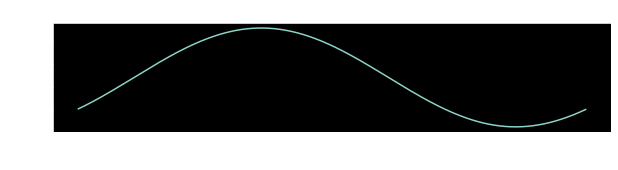

In [48]:
plt.plot(np.arange(0,365,1), y_om[0:365]); plt.gcf().set_size_inches(10,2)
plt.title('OM influx'); plt.xlabel('Day')
plt.ylabel('$mg\,C\,day^{-1}\,m^{-2}$')

#### GPP - actually it is not used by a biogeochemical model, just to know approximate range of values

In [49]:
sinusoidal(500,900,0.01,gpp) # returns maximum value of yearly gpp

602.0099999999072


In [50]:
m = 602
day = np.arange(0,1095,1)
# the same sinusoidal
y_gpp = m/16 + (m/2)*(1+np.sin(2*np.pi*(day-40)/365))

Text(0, 0.5, '$mg\\,C\\,day^{-1}\\,m^{-2}$')

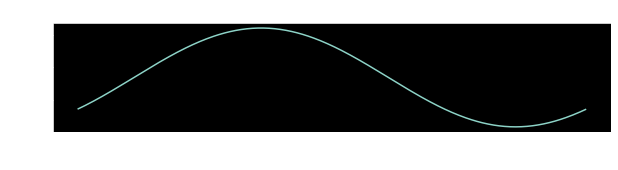

In [51]:
plt.plot(np.arange(0,365,1), y_gpp[0:365]); plt.gcf().set_size_inches(10,2)
plt.title('gpp'); plt.xlabel('Day')
plt.ylabel('$mg\,C\,day^{-1}\,m^{-2}$')

#### Generate a wadden_sea_out.nc file which consist of 3 successive similar years

In [52]:
import utilities as ut
import itertools as it
from netCDF4 import Dataset

rootgrp = Dataset("wadden_sea_out.nc", "w", format='NETCDF3_CLASSIC')

levelface = rootgrp.createDimension("levelface", 3)
levelcntr = rootgrp.createDimension("levelcntr", 2)
time = rootgrp.createDimension("time", 1095)

times = rootgrp.createVariable("time","f8",("time",))
times.units = "seconds since 2010-01-01 00:00:00.0"
times.calendar = "gregorian"

par = rootgrp.createVariable("par","f4",("time",))
par.units = "microM photons m−2 s−1"

hice = rootgrp.createVariable("hice","f4",("time",))
snowthick = rootgrp.createVariable("snowthick","f4",("time",))
icesurft = rootgrp.createVariable("icesurft","f4",("time",))

levelsface = rootgrp.createVariable("levelface","f4",("levelface",))
levelsface.units = "m"
levelscntr = rootgrp.createVariable("levelcntr","f4",("levelcntr",))
levelscntr.units = "m"
temperature = rootgrp.createVariable("temperature","f8",("time","levelcntr",))
temperature.units = "C degrees"
salinity = rootgrp.createVariable("salinity","f8",("time","levelcntr",))
salinity.units = "psu"
sigma = rootgrp.createVariable("sigma","f8",("time","levelcntr",))
sigma.units = "kg m-1"
turbulence = rootgrp.createVariable("turbulence","f8",("time","levelface",))
turbulence.units = "m2 s-1"

ammonium = rootgrp.createVariable("ammonium","f8",("time","levelcntr",))
ammonium.units = "mM N m-3"
nitrate = rootgrp.createVariable("nitrate","f8",("time","levelcntr",))
nitrate.units = "mM N m-3"
sulfate = rootgrp.createVariable("sulfate","f8",("time","levelcntr",))
nitrate.units = "mM S m-3"
silicate = rootgrp.createVariable("silicate","f8",("time","levelcntr",))
silicate.units = "mM Si m-3"
phosphate = rootgrp.createVariable("phosphate","f8",("time","levelcntr",))
phosphate.units = "mM P m-3"
oxygen = rootgrp.createVariable("oxygen","f8",("time","levelcntr",))
oxygen.units = "mM O2 m-3"
om = rootgrp.createVariable("om_flux","f8",("time","levelcntr",))
om.units = "mg C m-2 s-1"
chl_a = rootgrp.createVariable("chl_a","f8",("time","levelcntr",))
chl_a.units = "mg Chl a"

lvlface = np.array([2.5, 1.25, 0])
lvlcntr = np.array([1.875, 0.625])

levelsface[:] = lvlface
levelscntr[:] = lvlcntr

times[:] = df3years.index.values * 24 * 60 * 60
par[:] = par3years_generated
hice[:] = 0
snowthick[:] = 0
icesurft[:] = 0
temperature[:,:] = np.vstack((df3years.Temperature.values, df3years.Temperature.values)).T
salinity[:,:] = np.vstack((df3years.Salinity.values, df3years.Salinity.values)).T

#### Calculate eddy diffusivity, see utilities.py

In [53]:
sigma[:,0] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlcntr[0]))]
sigma[:,1] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlcntr[1]))]

In [54]:
sigmaface = np.zeros((1095,3))
sigmaface[:,0] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[0]))]
sigmaface[:,1] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[1]))]
sigmaface[:,2] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[2]))]
turbulence[:,0] = ut.gargett(sigmaface[:,0], 1)
turbulence[:,1] = ut.gargett(sigmaface[:,1], 1)
turbulence[:,2] = ut.gargett(sigmaface[:,2], 1)

In [55]:
ammonium[:,:] = 0.1
sulfate[:,:] = 25000
nitrate[:,:] = np.vstack((df3years.Nitrate.values, df3years.Nitrate.values)).T
silicate[:,:] = np.vstack((df3years.Silicate.values, df3years.Silicate.values)).T
phosphate[:,:] = np.vstack((df3years.Phosphate.values, df3years.Phosphate.values)).T
oxygen[:,:] = np.vstack((df3years.Oxygen.values, df3years.Oxygen.values)).T

In [56]:
chl_a[:,:] = np.vstack((df3years['Chlorophyll a'].values, df3years['Chlorophyll a'].values)).T

In [57]:
om[:,:] = np.vstack((om_input_3years/86400, om_input_3years/86400)).T

In [58]:
rootgrp.close()